# Understanding Gender Differences in Tweets with Deep Learning 

***

## Summer Chambers (ssc4mc), Keyu Chen (km5ar), Hannah Frederick (hbf3k)  

The .csv file that we read in can be found here: https://www.kaggle.com/crowdflower/twitter-user-gender-classification

The code that we source from can be found here: https://www.kaggle.com/gcdatkin/deep-recurrent-nn-for-gender-classification#Data-Every-Day

# Importing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import nltk
nltk.download('wordnet')
import pydot
import graphviz
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
data = pd.read_csv('gender-classifier-DFE-791531.csv', encoding='latin-1')

In [3]:
data

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20045,815757572,True,golden,259,NaN,female,1.0000,yes,1.0,8/5/15 21:16,...,https://pbs.twimg.com/profile_images/656793310...,0,C0DEED,"@lookupondeath ...Fine, and I'll drink tea too...",NaN,783,10/26/15 13:20,6.587400e+17,Verona ªÁ,NaN
20046,815757681,True,golden,248,NaN,male,1.0000,yes,1.0,8/15/12 21:17,...,https://pbs.twimg.com/profile_images/639815429...,0,0,Greg Hardy you a good player and all but don't...,NaN,13523,10/26/15 12:40,6.587300e+17,"Kansas City, MO",NaN
20047,815757830,True,golden,264,NaN,male,1.0000,yes,1.0,9/3/12 1:17,...,https://pbs.twimg.com/profile_images/655473271...,0,C0DEED,You can miss people and still never want to se...,NaN,26419,10/26/15 13:20,6.587400e+17,Lagos Nigeria,NaN
20048,815757921,True,golden,250,NaN,female,0.8489,yes,1.0,11/6/12 23:46,...,https://pbs.twimg.com/profile_images/657716093...,0,0,@bitemyapp i had noticed your tendency to pee ...,NaN,56073,10/26/15 12:40,6.587300e+17,Texas Hill Country,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

# Preprocessing

In [5]:
def get_sequences(texts, vocab_length):
    lemma = nltk.WordNetLemmatizer()
    texts = [lemma.lemmatize(word) for word in texts]

    tokenizer = Tokenizer(num_words=vocab_length)
    tokenizer.fit_on_texts(texts)
    
    sequences = tokenizer.texts_to_sequences(texts)
    
    max_seq_length = np.max([len(sequence) for sequence in sequences])
    
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences

In [6]:
def preprocess_input(df, vocab_length=20000):
    df = df.copy()
    
    # Drop unnecessary columns
    df = df[['gender','text', 'description']]
    
    # Encode unknown values in the target column as np.NaN
    df['gender'] = df['gender'].replace('unknown', np.NaN)
    
    # Drop rows with missing target values
    gender_nas = df[df['gender'].isna()].index
    df = df.drop(gender_nas, axis=0).reset_index(drop=True)

    # Drop rows with "brand" target values
    gender_brand = df[df['gender'] == 'brand'].index
    df = df.drop(gender_brand, axis=0).reset_index(drop=True)

    # Let's encode the missing values in the description column as empty strings
    df['description'] = df['description'].fillna('')

    # Get sequence data for text and description columns
    text = df['description'] + ' ' + df['text']
    text = get_sequences(text, vocab_length)
    
    # Encode label column
    label_mapping = {'female': 0, 'male': 1}
    df['gender'] = df['gender'].replace(label_mapping)
    
    # Get target data from gender column
    y = df['gender'].copy()
    
    return text, y

In [7]:
text, y = preprocess_input(data)

In [8]:
text.shape

(12894, 114)

In [9]:
y.shape

(12894,)

In [10]:
y.value_counts()

0    6700
1    6194
Name: gender, dtype: int64

# Splitting Train/Test Sets

In [11]:
text_train, text_test, y_train, y_test = train_test_split(text, y, train_size=0.8, random_state=1)

In [12]:
y_train.value_counts()

0    5342
1    4973
Name: gender, dtype: int64

In [13]:
y_test.value_counts()

0    1358
1    1221
Name: gender, dtype: int64

In [14]:
#! pip install scikit-learn==0.21.2

In [15]:
#! pip install numpy==1.19.3

# Modeling

In [16]:
def build_model(out_dim=256, train_bool=True, learning_rate=0.0001):

    text_inputs = tf.keras.Input(shape=(text.shape[1],))

    #text
    text_embedding = tf.keras.layers.Embedding(
        input_dim=20000,
        output_dim=out_dim,
        input_length=text.shape[1],
        trainable=train_bool
    )(text_inputs)
    text_gru = tf.keras.layers.GRU(out_dim, return_sequences=False)(text_embedding)
    text_flatten = tf.keras.layers.Flatten()(text_embedding)
    text_concat = tf.keras.layers.concatenate([text_gru, text_flatten])

    outputs = tf.keras.layers.Dense(2, activation='softmax')(text_concat)
    model = tf.keras.Model(inputs=text_inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])  
    return model

In [17]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [18]:
text_train.shape

(10315, 114)

In [19]:
y_train.shape

(10315,)

In [20]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "out_dim": [64, 128, 256, 512],
    "train_bool": [True, False],
    "learning_rate": np.arange(0.0001, 0.01, 0.002),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, random_state=0)
rnd_search_cv.fit(text_train, y_train, epochs=3,
                  callbacks=[keras.callbacks.EarlyStopping(monitor="loss", patience=10)])

Epoch 1/3
258/258 [==============================] - 382s 1s/step - loss: 0.8774 - accuracy: 0.5623
Epoch 2/3
167/258 [==================>...........] - ETA: 2:09 - loss: 0.1845 - accuracy: 0.9302

KeyboardInterrupt: 

In [ ]:
best_params = rnd_search_cv.best_params_
best_params

# Training

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 114)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 114, 256)     5120000     input_2[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 256)          394752      embedding_1[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 29184)        0           embedding_1[0][0]                
____________________________________________________________________________________________

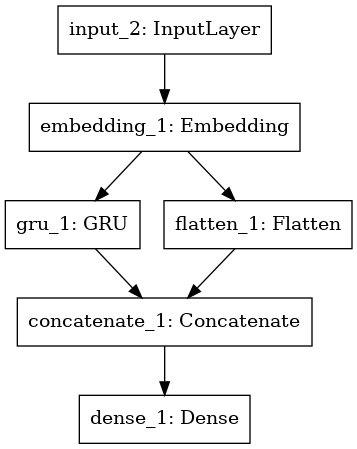

In [21]:
model = build_model()
print(model.summary())
tf.keras.utils.plot_model(model)

In [22]:
batch_size = 32
epochs = 10

best_params = {'train_bool': True, 'out_dim': 256, 'learning_rate': 0.0001}
model = build_model(out_dim=best_params["out_dim"], train_bool=best_params["train_bool"], learning_rate=best_params['learning_rate'])
model.fit(text_train,
          y_train,
          #batch_size=batch_size,
          epochs=epochs,
          callbacks=[keras.callbacks.EarlyStopping(monitor="loss", patience=10)])

Epoch 1/10
323/323 [==============================] - 155s 475ms/step - loss: 0.6927 - accuracy: 0.5144
Epoch 2/10
323/323 [==============================] - 140s 433ms/step - loss: 0.6700 - accuracy: 0.6067
Epoch 3/10
323/323 [==============================] - 141s 436ms/step - loss: 0.6356 - accuracy: 0.7379
Epoch 4/10
323/323 [==============================] - 144s 447ms/step - loss: 0.5749 - accuracy: 0.8094
Epoch 5/10
323/323 [==============================] - 146s 452ms/step - loss: 0.4901 - accuracy: 0.8687
Epoch 6/10
323/323 [==============================] - 142s 441ms/step - loss: 0.4048 - accuracy: 0.9157
Epoch 7/10
323/323 [==============================] - 140s 434ms/step - loss: 0.3262 - accuracy: 0.9468
Epoch 8/10
323/323 [==============================] - 153s 473ms/step - loss: 0.2632 - accuracy: 0.9641
Epoch 9/10
323/323 [==============================] - 140s 435ms/step - loss: 0.2056 - accuracy: 0.9784
Epoch 10/10
323/323 [==============================] - 140s 434m

In [ ]:
import os
model_name = "gru_model"
model_version = "0001"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: gru_model/0001/assets
INFO:tensorflow:Assets written to: gru_model/0001/assets


# Results

In [24]:
results = model.evaluate(text_test, y_test, verbose=True)
print("Model Accuracy: {:.2f}%".format(results[1] * 100))

81/81 [==============================] - 8s 99ms/step - loss: 0.6055 - accuracy: 0.6661
Model Accuracy: 66.61%


In [25]:
y_true = np.array(y_test)

y_pred = model.predict(text_test)
y_pred1 = map(lambda x: np.argmax(x), y_pred)
y_pred1 = np.array(list(y_pred1))

In [26]:
y_true

array([0, 1, 0, ..., 1, 1, 0])

In [27]:
y_pred1

array([0, 0, 0, ..., 1, 1, 0])

In [28]:
cm = confusion_matrix(y_true, y_pred1)
clr = classification_report(y_true, y_pred1, target_names=['female', 'male'])

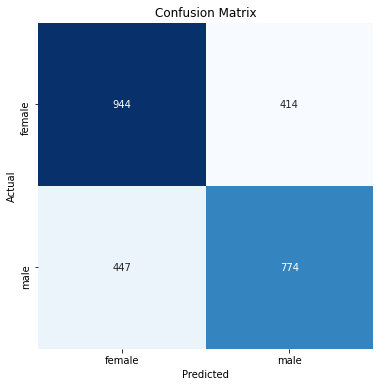

In [29]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2) + 0.5, ['female', 'male'])
plt.yticks(np.arange(2) + 0.5, ['female', 'male'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [30]:
print("Classification Report:\n\n", clr)

Classification Report:

               precision    recall  f1-score   support

      female       0.68      0.70      0.69      1358
        male       0.65      0.63      0.64      1221

    accuracy                           0.67      2579
   macro avg       0.67      0.66      0.66      2579
weighted avg       0.67      0.67      0.67      2579



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=018075c4-cccb-4808-bac8-50a3988dbc16' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>